# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
unique_labels = set()
for label in train['labels']:
    unique_labels.add(label)
n_classes = len(unique_labels)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import matplotlib.cbook as cbook
import numpy as np
import random
import time
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

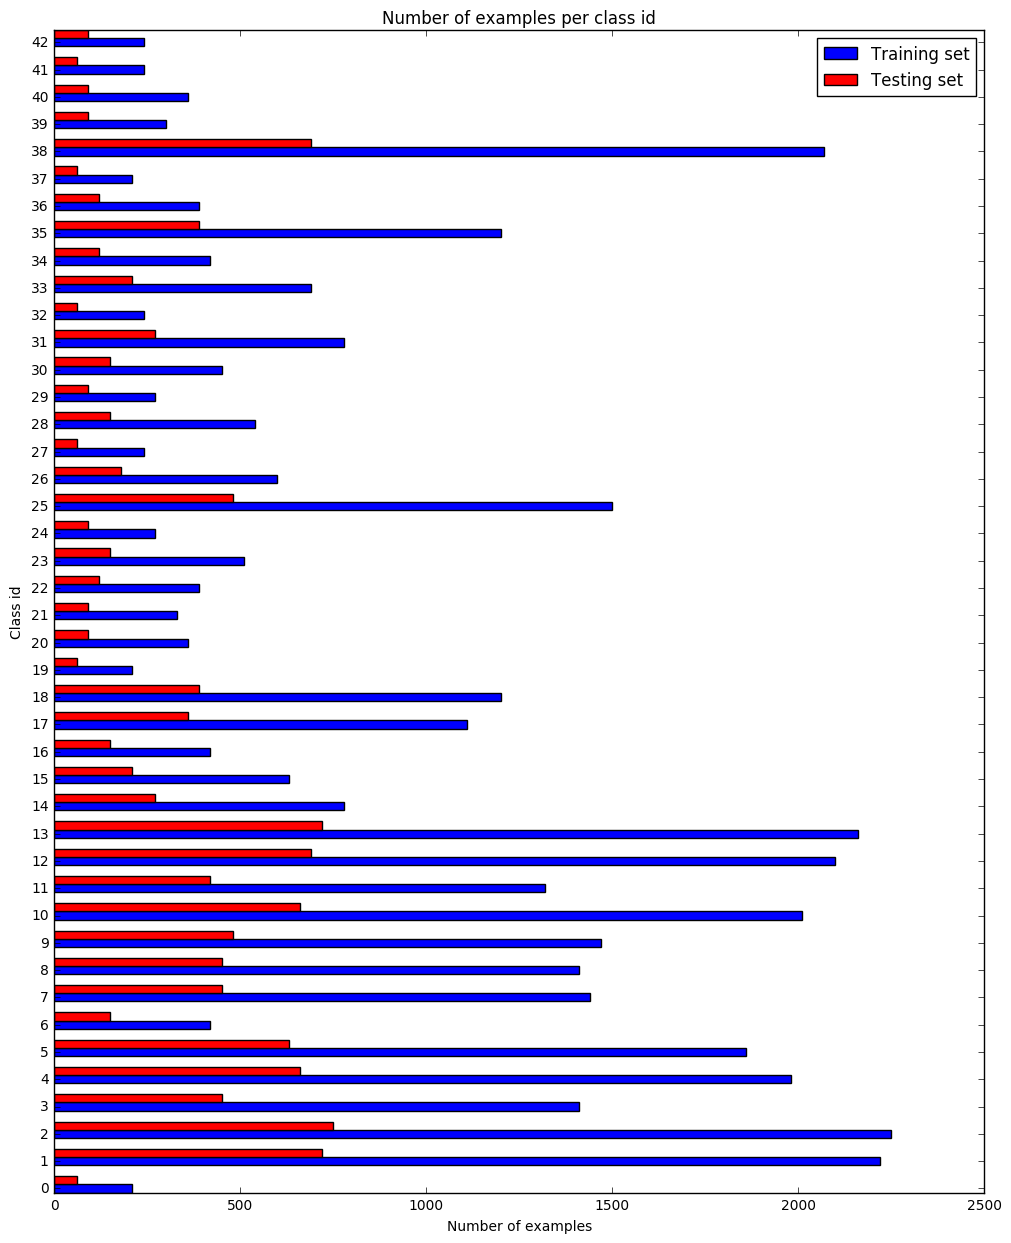

In [4]:
### Number of examples per class id

def label_count_map(labels):
    """Returns a map with the label as a key and the number of occurence of the label as a value"""
    count_map = {}
    for l in labels:
        count = count_map.get(l)
        if count is None:
            count = 0;
        count = count+1;
        count_map[l] = count;
    return count_map

bar_height = .3

plt.figure(figsize=(12,15))
plt.title('Number of examples per class id')
plt.ylabel('Class id')
plt.xlabel('Number of examples')
plt.yticks(np.arange(n_classes))

train_count_map = label_count_map(train['labels'])
y = np.array(list(train_count_map.keys()))
x = train_count_map.values()
plt.barh(y, x, bar_height, color='b', align='center', label="Training set")

test_count_map = label_count_map(test['labels'])
y = np.array(list(test_count_map.keys())) + bar_height
x = test_count_map.values()
plt.barh(y, x, bar_height, color='r', align='center', label="Testing set")
plt.legend()

In [5]:
# Create a map to go from class id to class string
from numpy import loadtxt
key_value = loadtxt("signnames.csv", dtype={'names': ('key', 'description'),'formats': ('i2', 'S50')}, delimiter=",", skiprows=1)
classes = { int(k):v.decode('ascii') for k,v in key_value }

In [6]:
from collections import defaultdict

def group_by_label(features, labels):
    """Returns a map having a label as a key and a list of features of the given label as a value"""
    assert(len(features) == len(labels))
    out = defaultdict(list)
    for i in range(len(features)):
        f = features[i]
        l = labels[i]
        out[l].append(f)
    return out

import matplotlib.gridspec as gridspec

def sneak_peek(features, labels):
    """Draws randomly 5 images per label"""
    mapping = group_by_label(features, labels)
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(n_classes, 6, top=4, bottom=-2)

    for i in range(n_classes):
        image_list = mapping[i]
        label = str(classes[i])
        for j in range(0, 6):
            axis = fig.add_subplot(gs[i, j])
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            if j == 0:
                text = "%d - %s" % (i,label)
                axis.text(0, 0, text, fontsize=8, wrap=True)
                axis.axison=False
            else:
                rand_index = random.randint(0, len(image_list) - 1)
                axis.imshow(image_list[rand_index], interpolation='nearest')
    plt.show()

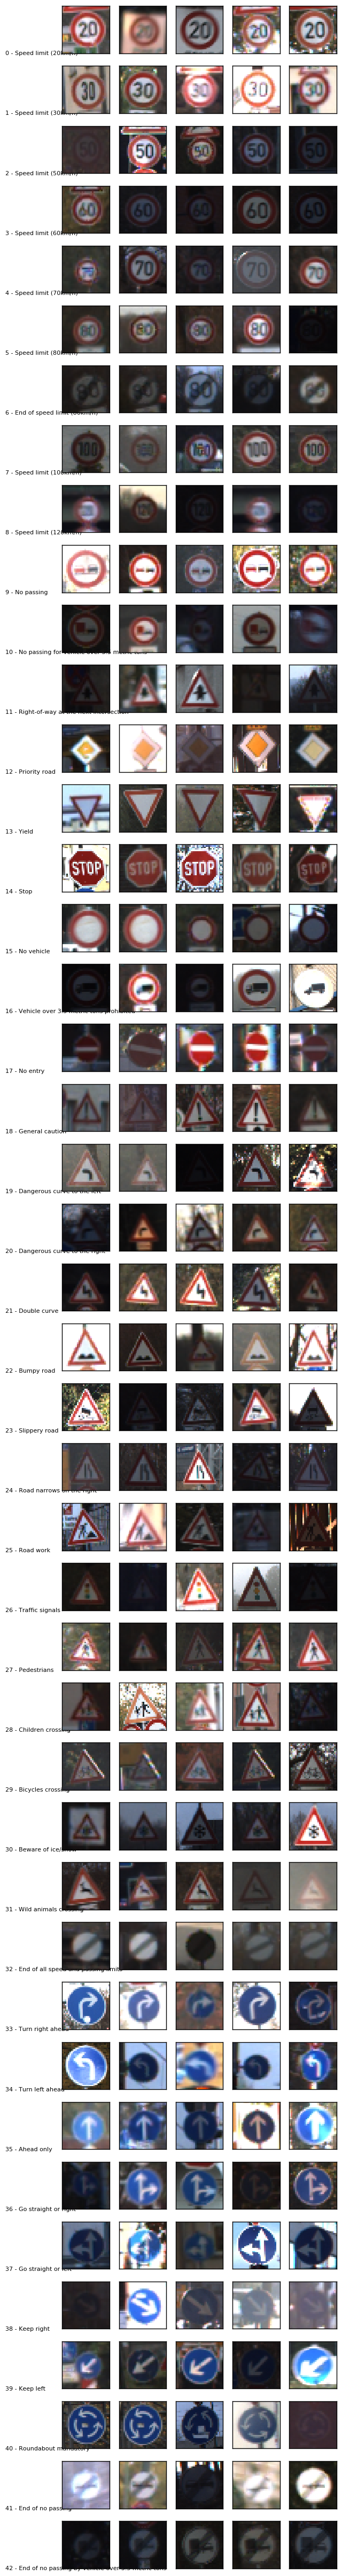

In [7]:
sneak_peek(train['features'], train['labels'])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
# Split training into training and validation (this also does the shuffle)
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Number of training examples =", len(X_train))
print("Number of validation examples =", len(X_validation))
print("Number of testing examples =", len(X_test))

Number of training examples = 31367
Number of validation examples = 7842
Number of testing examples = 12630


In [9]:
import cv2

def jitter_image(img, scale=0.1, rotation=15, translation=2, shear=0.05):
    """Jitter a given image.
    This is used to augment the dataset by generating new images with minor affine transformations"""
    rows,cols,_ = img.shape 
    
    # Scale matrix
    scale_x = np.random.uniform(1-scale, 1+scale)
    scale_y = np.random.uniform(1-scale, 1+scale)
    scale_m = np.float32([[scale_x, 0, 0], [0, scale_y,0]])
    # Apply scale
    #img = cv2.warpAffine(img, scale_m, (cols,rows))
    
    # Rotation matrix
    rot = np.random.uniform(-rotation, rotation)
    rot_m = cv2.getRotationMatrix2D((cols/2, rows/2), rot, 1)
    # Apply rotation
    img = cv2.warpAffine(img, rot_m, (cols,rows))
    
    # Translation matrix
    trans_x = np.random.uniform(-translation, translation)
    trans_y = np.random.uniform(-translation, translation)
    trans_m = np.float32([[1,0,trans_x], [0,1,trans_y]])
    # Apply translation
    # img = cv2.warpAffine(img, trans_m, (cols,rows))
    
    # Shear matrix
    max_x = cols * shear
    rand_x_1 = np.random.uniform(-max_x, max_x)
    rand_x_2 = np.random.uniform(-max_x, max_x)
    rand_x_3 = np.random.uniform(-max_x, max_x)
    max_y = rows * shear
    rand_y_1 = np.random.uniform(-max_y, max_y)
    rand_y_2 = np.random.uniform(-max_y, max_y)
    rand_y_3 = np.random.uniform(-max_y, max_y)
    pts1 = np.float32([[0,0],[cols,0],[0,rows]])
    pts2 = np.float32([[rand_x_1,rand_y_1],[cols + rand_x_2,rand_y_2],[rand_x_3,rows + rand_y_3]])
    shear_m = cv2.getAffineTransform(pts1, pts2)
    # Apply shear
    img = cv2.warpAffine(img, shear_m, (cols,rows))
    
    return img

Sample jitter on a single image


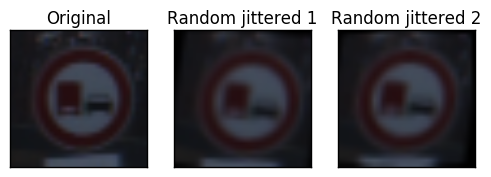

In [10]:
### Test augmentation technique on a single image
def sample_jitter(image):
    """Apply jitter logic to given image and display original and jittered images"""
    fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)
    ax1.imshow(image)
    ax1.set_title('Original')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax2.imshow(jitter_image(image))
    ax2.set_title('Random jittered 1')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    ax3.imshow(jitter_image(image))
    ax3.set_title('Random jittered 2')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)

# Apply jitter to a single image
print("Sample jitter on a single image")  
sample_index = random.randint(0, len(X_train))
sample_image = X_train[sample_index]  
sample_jitter(sample_image) 

Number of training examples = 31367
Number of training examples after augmentation = 156835


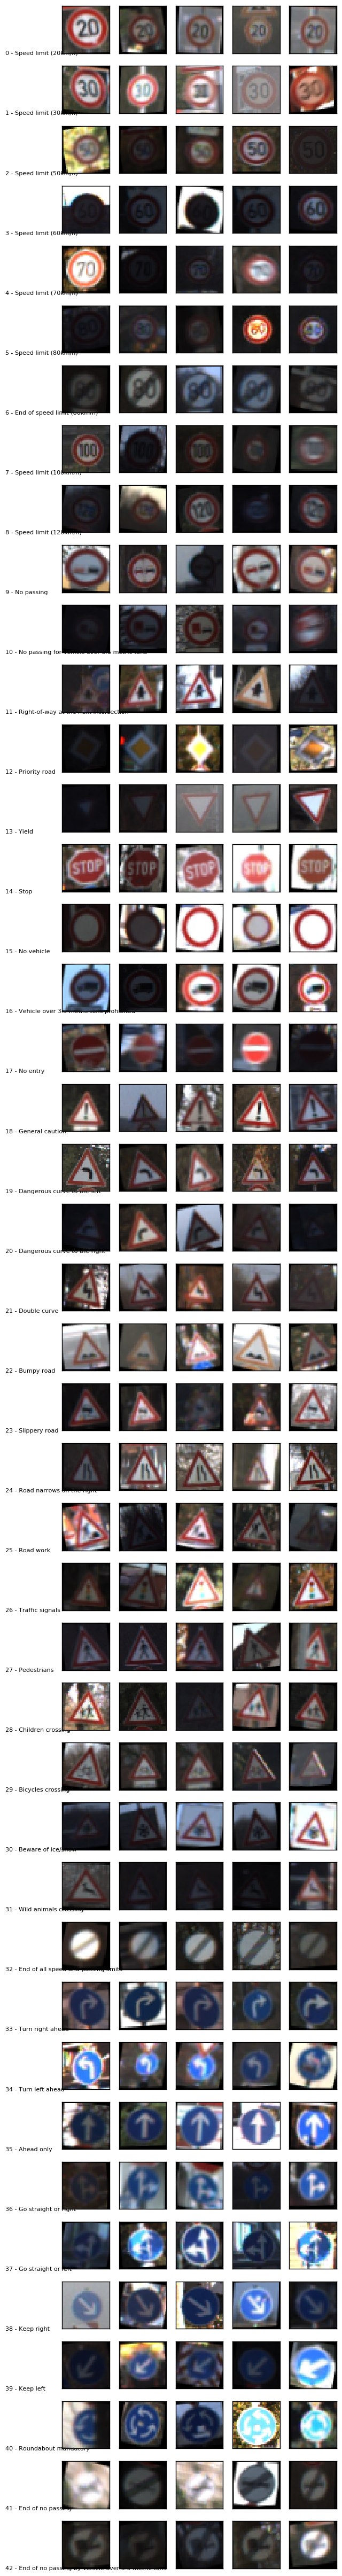

In [11]:
# Training set augmentation 
def jitter_dataset(dataset, labels):
    """Returns an augmented dataset by adding jittered images"""
    assert(len(dataset) == len(labels))
    
    dataset_tmp = []
    labels_tmp = []
    for i in reversed(range(len(dataset))):
        for j in range(4):
            img = jitter_image(dataset[i])
            dataset_tmp.append(img)
            labels_tmp.append(labels[i])

    new_dataset = np.append(dataset, dataset_tmp, axis=0)
    new_labels = np.append(labels, labels_tmp, axis=0)
    
    return new_dataset, new_labels

print("Number of training examples =", len(X_train))
X_train, y_train = jitter_dataset(X_train, y_train)
print("Number of training examples after augmentation =", len(X_train))

sneak_peek(X_train, y_train)

In [12]:
### All helper methods used for preprocessing
from sklearn.preprocessing import LabelBinarizer
    
def normalize(image_data):
    """Normalize all channels of given image to [-0.5, 0.5]"""
    return  image_data / 255 - 0.5 
    
def preprocess_image(image):
    """Apply the preprocess pipeline to the given image"""
    return normalize(image)

In [13]:
### Preprocess on all images
def preprocess_collection(collection):
    if (collection.dtype != np.float32 or collection.dtype != np.float64):
        collection = collection.astype(dtype=np.float32)
    
    for i in range(len(collection)):
        collection[i] = preprocess_image(collection[i])
        
    return collection
    
print('Preprocessing images...')
# Normalization of all channels
X_train = preprocess_collection(X_train)
X_validation = preprocess_collection(X_validation)
X_test = preprocess_collection(X_test)

Preprocessing images...


In [14]:
# Training
EPOCHS = 19
BATCH_SIZE = 512
KEEP_PROBABILITY = 0.5
# Optimizer
LEARNING_RATE = 0.001

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Regularization.
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
keep_prob = tf.placeholder(tf.float32)
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

# Evaluate
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
start_time = time.clock()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROBABILITY})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'model')
    print("Model saved")
    
elapsed_time = time.clock() - start_time
print("Training took %d seconds" % elapsed_time)

Training...

EPOCH 1 ...
Validation Accuracy = 0.843
Test Accuracy = 0.792

EPOCH 2 ...
Validation Accuracy = 0.929
Test Accuracy = 0.875

EPOCH 3 ...
Validation Accuracy = 0.952
Test Accuracy = 0.903

EPOCH 4 ...
Validation Accuracy = 0.965
Test Accuracy = 0.920

EPOCH 5 ...
Validation Accuracy = 0.973
Test Accuracy = 0.924

EPOCH 6 ...
Validation Accuracy = 0.978
Test Accuracy = 0.930

EPOCH 7 ...
Validation Accuracy = 0.982
Test Accuracy = 0.933

EPOCH 8 ...
Validation Accuracy = 0.985
Test Accuracy = 0.934

EPOCH 9 ...
Validation Accuracy = 0.985
Test Accuracy = 0.937

EPOCH 10 ...
Validation Accuracy = 0.988
Test Accuracy = 0.939

EPOCH 11 ...
Validation Accuracy = 0.989
Test Accuracy = 0.941

EPOCH 12 ...
Validation Accuracy = 0.988
Test Accuracy = 0.947

EPOCH 13 ...
Validation Accuracy = 0.987
Test Accuracy = 0.943

EPOCH 14 ...
Validation Accuracy = 0.989
Test Accuracy = 0.947

EPOCH 15 ...
Validation Accuracy = 0.989
Test Accuracy = 0.947

EPOCH 16 ...
Validation Accuracy = 0

In [16]:
# Evaluate model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.950


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Each channel of the image is normalized within the [-0.5, 0.5] range. Having the data set with a mean of 0 and equalized covariance will help the neural network to converge faster, that was my motivation into normalizing each channel.

Colors in traffic signs can help to distingsh signs, for instance only a few traffic signs have the yellow color. Therefore, I decided to keep the color information and did not go grayscale. Images from the dataset are in RGB format, I had not valid reason to change the format.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The training set has bet cut in two folds, one of 80% that is the training set used to train the model, and the 20% left are used as a validation set. This means our training set has 31,367 images and our validation set has 7,842 images.
Cross validation could have been considered, but I decided to not implement it as the training set is big enough that we should no suffer from keeping the validation out of the training loop.

In order to make the model resiliant to scale, translation and orientation I decided to generate additional data. Generation is done by adding jittered images from the training set. I followed the technique discribed in "Traffic Sign Recognition with Multi-Scale Convolutional Networks" paper from Pierre Sermanet and Yann LeCun, by adding 5 transformed version of the original image from the training set. Samples are randomly perturbed in scale ([.9,1.1] ratio), in position ([-2,2] pixels) and rotation ([-15,+15] degrees). After applying this technique the training set has 156,835 images.

I've noticed that the dataset in unbalanced, not all labels have the same number of sample in the training and test set. The unbalanced training set  means the model trained will be more accurate for the most represented classes. The unbalanced testing set means the test will focus more on some labels than other. I noted those two disparities but I decided to not tackle it.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The used the LeNet architecture, which is dedicated to features recognition in images. It has 2 convolutional layers (output of 28x28x6 and 10x10x16) followed by 3 fully connected layers (output of 120, 84 and 43). Each layer uses a Relu as an activation (to provide a non linear response). The two convolutional layers also have a max pooling after the activation (output of 14x14x6 and 5x5x6). I introduced one single change to the LeNet architecture, it's a regularization, a dropout, after the last convolution and the beginning of the fully connected layers. My addition to the LeNet architecture should help the model to rely on more than one feature to classify.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The optimizer used is Adam.
The batch size has been maxed out to 512 which yields a memory usage under 4GB.
The model is trained over 16 epochs. The keep probability of the dropout is set to 50%.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with LeNet architecture which is designed to classify small resolution images. I had results in the 80% accuracy rate. From there I tried to increase the number of epochs but I could see the validation accuracy goind back and forth (over correcting). So I decided to add a regularization to the existing architecture. The intention was to add some noise and indirectly slow down the learning rate. With the dropout's keep probability at 50%, the accuracy of the model bumped to 95%. I decided to stop there.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

(-0.5, 31.5, 31.5, -0.5)

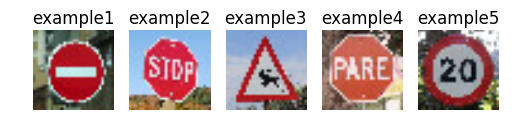

In [17]:
import matplotlib.image as mpimg

example1 = mpimg.imread('signs/example1.jpg') # class 17
example2 = mpimg.imread('signs/example2.jpg') # class 14
example3 = mpimg.imread('signs/example3.jpg') # class 31
example4 = mpimg.imread('signs/example4.jpg') # class 14
example5 = mpimg.imread('signs/example5.jpg') # class 0

correct_class = [17, 14, 31, 14, 0]

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(nrows=1, ncols=5)

ax1.imshow(example1)
ax1.set_title('example1')
ax1.axis("off")

ax2.imshow(example2)
ax2.set_title('example2')
ax2.axis("off")

ax3.imshow(example3)
ax3.set_title('example3')
ax3.axis("off")

ax4.imshow(example4)
ax4.set_title('example4')
ax4.axis("off")

ax5.imshow(example5)
ax5.set_title('example5')
ax5.axis("off")

In [18]:
input = np.array([example1, example2, example3, example4, example5])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    prediction = tf.nn.softmax(logits)
    top_five_prediction = tf.nn.top_k(prediction, k=5, sorted = True)
    prediction_result = sess.run(top_five_prediction, feed_dict={x: input, keep_prob:1})

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I decide to add one image, example4, that contains some text in spanish.
This image differt from our dataset only by the text and not by the shape or color. It will be interesting to see if our model will make a correct guess.

Other images, should not present any major difficulty for the classification.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
Our model has a testing accuracy of 80% which is far from the 95% accuracy we had on the training set. As a result, I believe my model did not perform well in real world situation. I suspect resolution and the drawing of an icon on the wild animal crossign sign on my test image to be too different/too poor quality compared to what I have in my training set. I did not anticipate this problem. This specific sign has been misclassified as a double curve sign, we can notate that both signs, wild animal corssing and double curve sign, are distinguished only by the icon at the center of the sign, which validate my theory.

In [19]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

print(prediction_result)
print(correct_class)

TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[17,  0,  1,  2,  3],
       [14,  0,  1,  2,  3],
       [21,  0,  1,  2,  3],
       [17,  0,  1,  2,  3],
       [ 0,  1,  2,  3,  4]], dtype=int32))
[17, 14, 31, 14, 0]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The model has been certain in almost all predictions (>0.9). But example3 of the wild animal crossing has not been classified correctly despite a certain prediction of 1. The correct classified doesn't appear in the top 5, I suspect this is due to the somehow poor definition of the animal drawn on the sign.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.